In [2]:
import ete3
import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
import re
import multiprocessing
import subprocess
#import plotly
#import plotly.plotly as ptl
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%cd /work/site_rate/hemimastigophora

/work/site_rate/hemimastigophora


In [3]:
trees = []
names = []
random.seed(12345)
for category in range(1,13):
    ufboot = open('categories/%i.boot.ufboot' % category).read().split('\n')
    ufboot.pop()
    trees.extend(random.sample(ufboot, 100))
    names.extend(['rate_%i' % category]*100)

trees.append(open('CAT_61tax_h0.42_g1.bmge.fas.UFboot.tre').read().strip())
names.append('CAT_61tax_h0.42_g1.bmge')
#trees.append(open('CAT_58tax-nDP_h0.42_g1.bmge.fas.UFboot.tre').read().strip())
#names.append('CAT_58tax-nDP_h0.42_g1.bmge')
#trees.append(open('CAT_58tax-nLB_h0.42_g1.bmge.fas.UFboot.tre').read().strip())
#names.append('CAT_58tax-nLB_h0.42_g1.bmge')

In [4]:
for filename in os.listdir('selected_categories/'):
    if not filename.endswith('.ufboot'):
        continue
    ufboot = open('selected_categories/%s' % filename).read().split('\n')
    ufboot.pop()
    trees.extend(random.sample(ufboot, 100))
    names.extend([filename.replace('.aln.ufboot', '')]*100)

In [39]:
for treefile in os.listdir('7_tree files/61-SFSR'):
    if treefile.endswith('.tre') and '.bmge' in treefile:
        tree_txt = open('7_tree files/61-SFSR/%s' % treefile).read().strip()
        trees.append(re.sub(r'\[\\\[&label=\S+?\\\]\]', '', tree_txt))
        names.append(treefile.replace('.fas.tre', ''))

In [5]:
out = open('rf_trees.treelist', 'w')
out.write('\n'.join(trees))
out.close()

#subprocess.call(['iqtree', '-t', 'rf_trees.treelist', '-rf_all'])
subprocess.call(['raxmlHPC-PTHREADS-SSE3', '-m', 'GTRCAT', '-N', '15',
                 '-z', 'rf_trees.treelist', '-f', 'r', '-n', 'rf_distances'])
distances = []
for line in open('RAxML_RF-Distances.rf_distances').readlines():
    distances.append(float(line.split()[-1]))

df = pd.DataFrame(index=names, columns=names, data=squareform(distances))

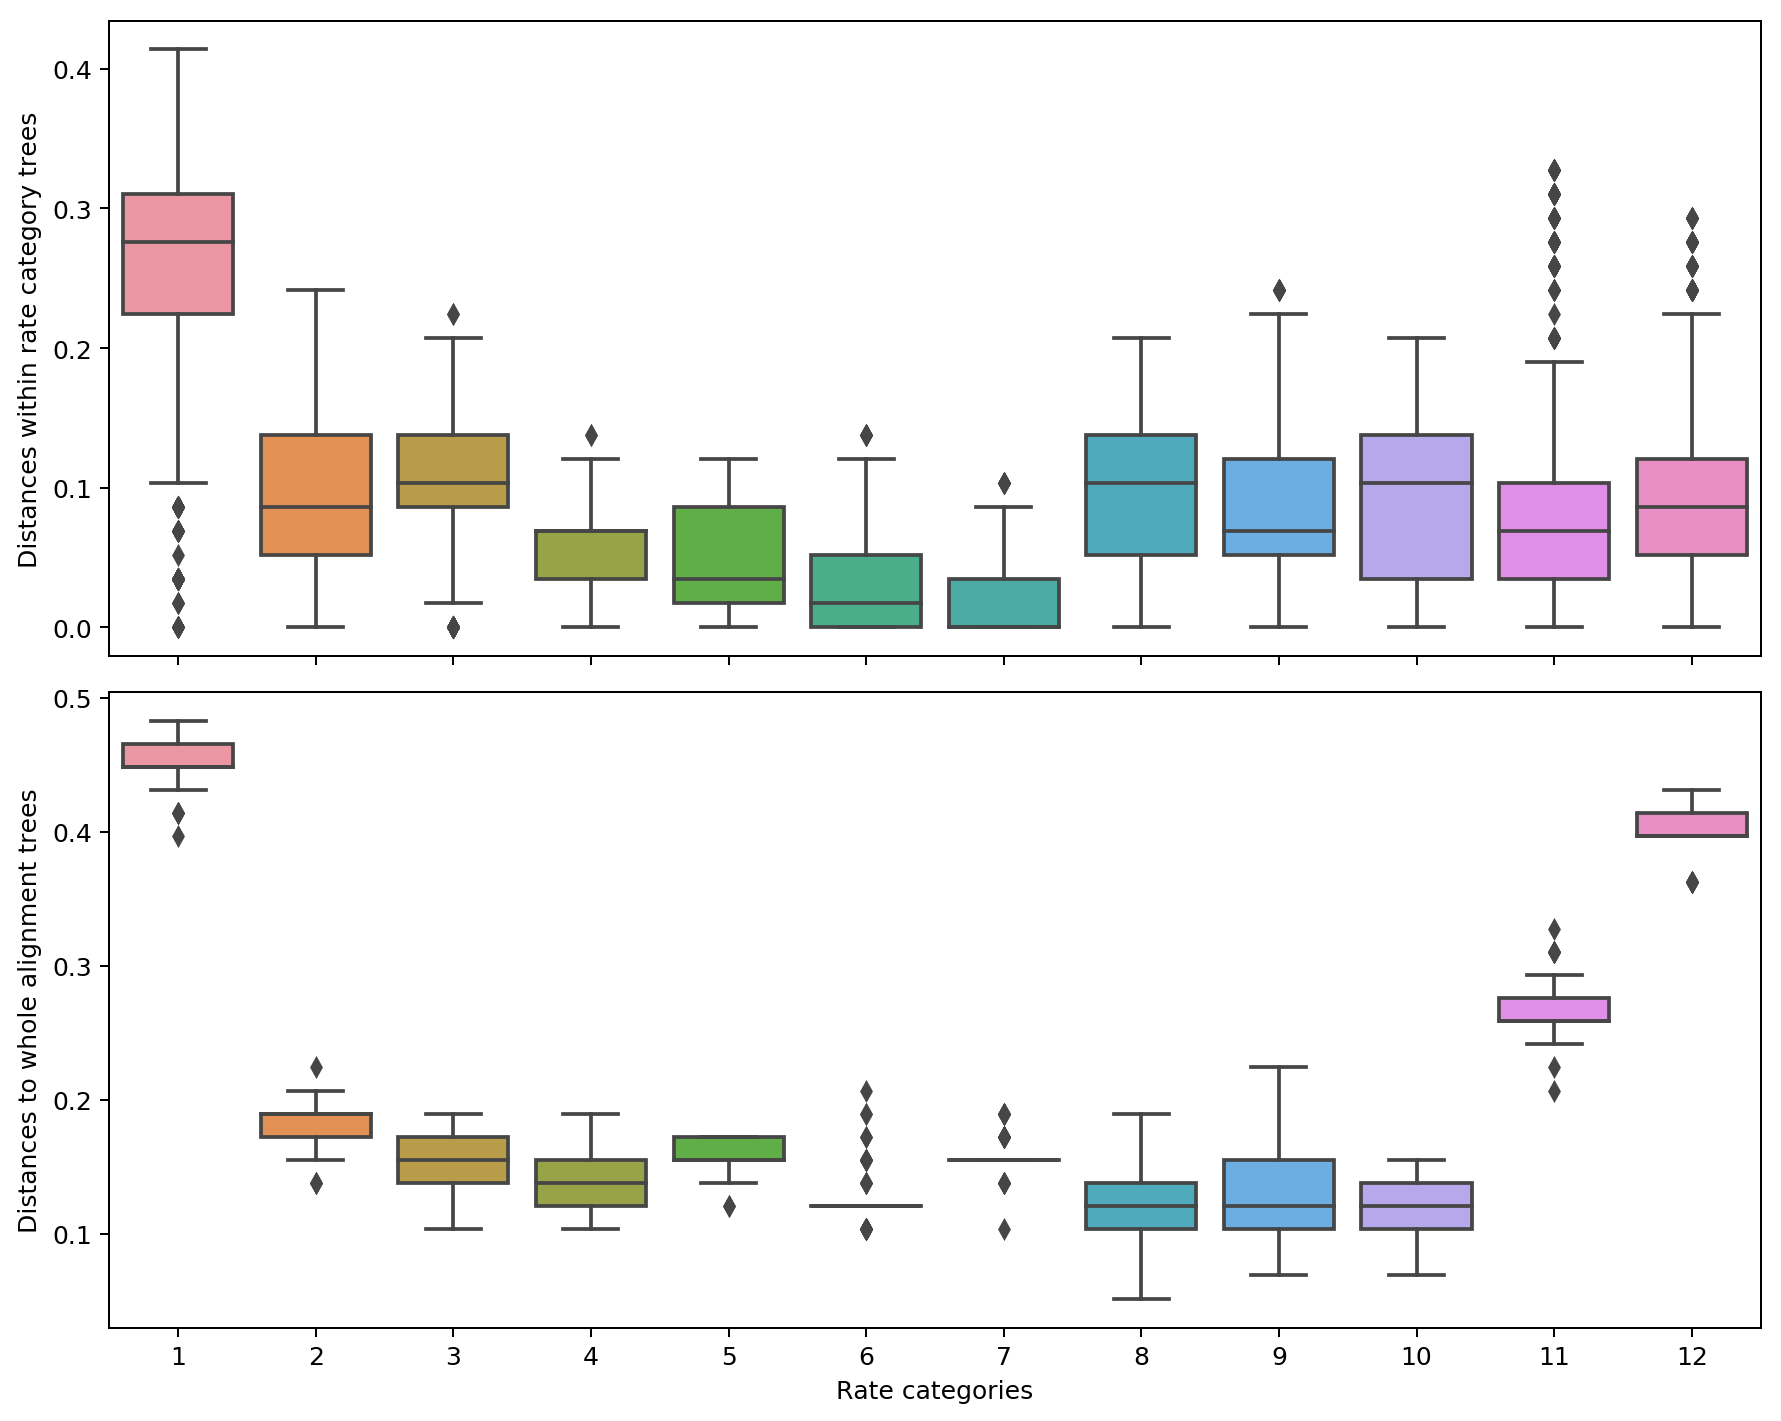

In [4]:
intra_distances = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='rate_%i' % category].copy()
    intra_distances.append(squareform(tmp_df.values))

fig, axs = plt.subplots(nrows=2, sharex=True, dpi=180, figsize=(10,8))
sns.boxplot(x=range(1,13), y=intra_distances, ax=axs[0])
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('whole')]
distances_to_whole_aln = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='CAT_61tax_h0.42_g1.bmge'].copy()
    distances_to_whole_aln.append(tmp_df.values.flatten())
    
sns.boxplot(x=range(1,13), y=distances_to_whole_aln, ax=axs[1])
axs[1].set_ylabel('Distances to whole alignment trees')
axs[1].set_xlabel('Rate categories')

fig.tight_layout()

In [7]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=6)
coords    = embedding.fit_transform(df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=df.index)
        
coords_df['gene_type'] = coords_df.index.tolist()

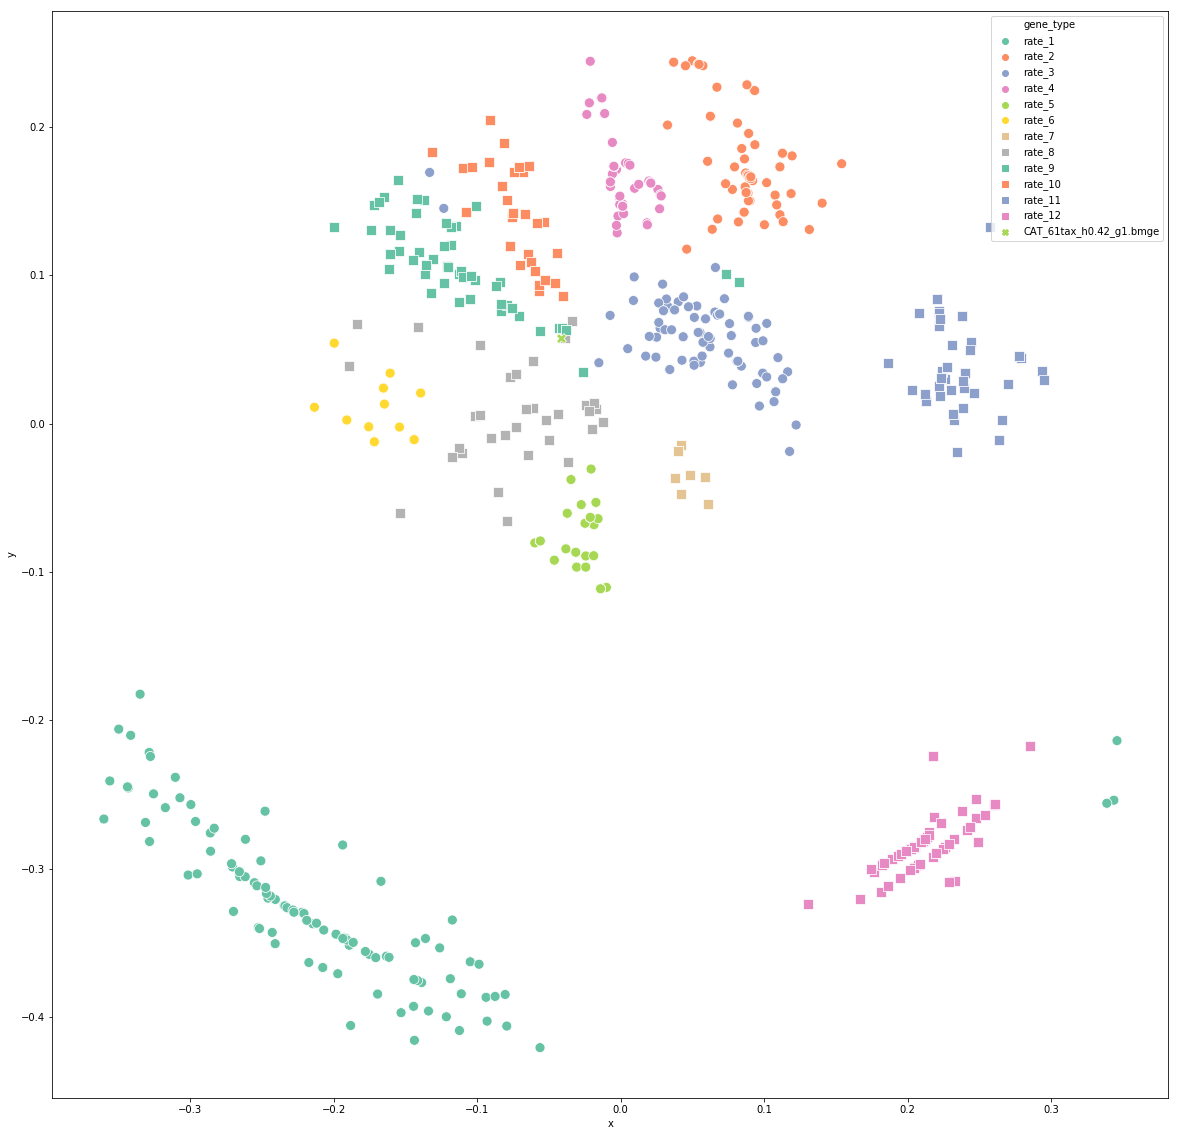

In [32]:
markers = {'rate_%i' % num:'o' for num in range(1,7)}
markers.update({'rate_%i' % num:'s' for num in range(7,13)})
markers['CAT_61tax_h0.42_g1.bmge'] = 'X'
#markers['CAT_58tax-nDP_h0.42_g1.bmge'] = 'X'
#markers['CAT_58tax-nLB_h0.42_g1.bmge'] = 'X'
fig, ax = plt.subplots(figsize=(20,20))
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df,
                ax=ax, s=100, palette="Set2",
                markers=markers, alpha=1)

In [10]:
cmap        = plt.get_cmap('rainbow')
color_range = ['#%02x%02x%02x' % cmap(value, bytes=True)[:3] for value in np.linspace(0, 1, 8)]
data        = []
marker_shapes = ['circle', 'square', 'triangle-up', 'diamond', 'star']
for gene_type, (shape,color) in zip(coords_df.gene_type.unique(), product(marker_shapes, color_range)):
    tmp    = coords_df[coords_df.gene_type == gene_type]
    
    data.append(
        go.Scatter(x=tmp.x.values, y=tmp.y.values, mode='markers', text=tmp.index,
               name=gene_type, hoverinfo='text', showlegend=True,
               marker=dict(size=[20 if index.endswith('.bmge') or index.startswith('missing') else 10
                                   for index in tmp.index],color=color, opacity=.7,
                           symbol=['star' if index.endswith('.bmge') or index.startswith('missing') else shape
                                   for index in tmp.index])
        )
    )
layout    = go.Layout(title='Geodesic distances', hovermode='closest', width=1200, height=1000)
fig       = go.Figure(data=data, layout=layout)
iplot(fig)

In [66]:
list(product(color_range, marker_shapes))

[('#7f00ff', 'circle'),
 ('#7f00ff', 'square'),
 ('#7f00ff', 'triangle-up'),
 ('#7f00ff', 'diamond'),
 ('#7f00ff', 'star'),
 ('#4756fb', 'circle'),
 ('#4756fb', 'square'),
 ('#4756fb', 'triangle-up'),
 ('#4756fb', 'diamond'),
 ('#4756fb', 'star'),
 ('#0fa2ef', 'circle'),
 ('#0fa2ef', 'square'),
 ('#0fa2ef', 'triangle-up'),
 ('#0fa2ef', 'diamond'),
 ('#0fa2ef', 'star'),
 ('#2adcdc', 'circle'),
 ('#2adcdc', 'square'),
 ('#2adcdc', 'triangle-up'),
 ('#2adcdc', 'diamond'),
 ('#2adcdc', 'star'),
 ('#62fac3', 'circle'),
 ('#62fac3', 'square'),
 ('#62fac3', 'triangle-up'),
 ('#62fac3', 'diamond'),
 ('#62fac3', 'star'),
 ('#9cfaa3', 'circle'),
 ('#9cfaa3', 'square'),
 ('#9cfaa3', 'triangle-up'),
 ('#9cfaa3', 'diamond'),
 ('#9cfaa3', 'star'),
 ('#d4dc7f', 'circle'),
 ('#d4dc7f', 'square'),
 ('#d4dc7f', 'triangle-up'),
 ('#d4dc7f', 'diamond'),
 ('#d4dc7f', 'star'),
 ('#ffa256', 'circle'),
 ('#ffa256', 'square'),
 ('#ffa256', 'triangle-up'),
 ('#ffa256', 'diamond'),
 ('#ffa256', 'star'),
 ('#ff56